# From SpaCy's neuralcoref to hypergraph.Diagram

This notebook must be run in a virtual environment with neuralcoref imported from source.

In [1]:
import spacy
import neuralcoref

nlp = spacy.load('en')
neuralcoref.add_to_pipe(nlp)
doc1 = nlp("A pair of starcross lovers take their life")
doc2 = nlp(", whose misadventured piteous overthrows doth with their death bury their parent's strife.")

In [2]:
from discopy import operad

def find_root(doc):
    for word in doc:
        if word.dep_ == 'ROOT':
            return word

def doc2tree(root, lexicalised=False):
    children = list(root.children)
    if not children:
        return operad.Box(root.text, operad.Ob(root.dep_), [operad.Ob(root.text)]) \
            if lexicalised else operad.Box(root.text, operad.Ob(root.dep_), [])
    box = operad.Box(root.text, operad.Ob(root.dep_), [operad.Ob(child.dep_) for child in children])
    return box(*[doc2tree(child, lexicalised=lexicalised) for child in children])

def from_spacy(doc, lexicalised=False):
    root = find_root(doc)
    return doc2tree(root, lexicalised=lexicalised)

In [3]:
from discopy.operad import tree2diagram

# tree2diagram(from_spacy(doc1, lexicalised=True)).draw()

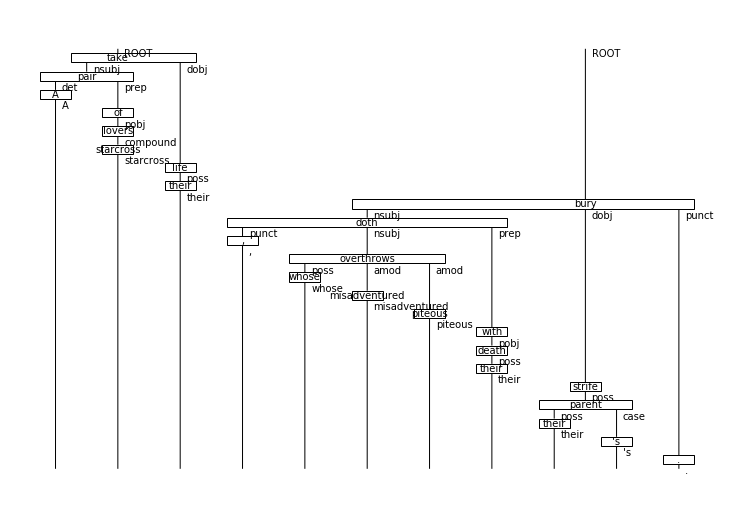

In [4]:
from discopy import rigid
from discopy.hypergraph import Ty, Box, Diagram

F = rigid.Functor(ob=lambda typ: Ty(typ[0]),
                  ar=lambda box: Box(box.name, box.dom, box.cod),
                  ob_factory=Ty, ar_factory=Diagram)

text = F(tree2diagram(from_spacy(doc1, lexicalised=True))) @ F(tree2diagram(from_spacy(doc2, lexicalised=True)))
assert text.is_monogamous
text.downgrade().draw(figsize=(10, 7))

[A pair of starcross lovers: [A pair of starcross lovers, their, their, their]]


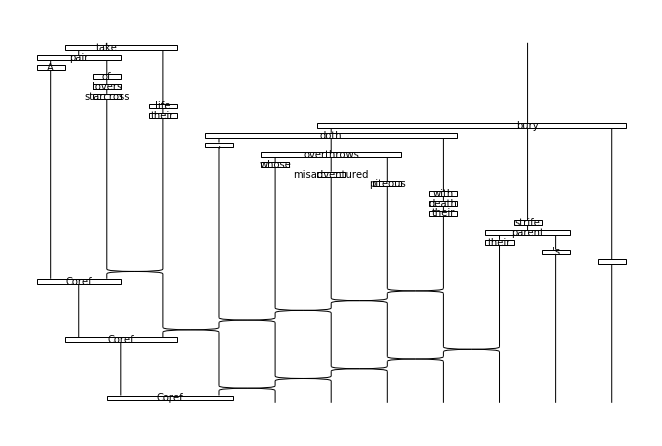

In [5]:
from discopy.rigid import Ob
from discopy.hypergraph import Ty, Id, Box, Diagram

ref = lambda x, y: Box('Coref', Ty(x, y), Ty(x))
units = lambda ty: Box('Unit', ty, Ty())

def coref(diagram, word0, word1):
    pos0, pos1 = diagram.cod.objects.index(word0), diagram.cod.objects.index(word1)
    swaps = Id(Ty(word0)) @ Diagram.swap(diagram.cod[pos0 + 1 or pos1:pos1], Ty(word1))
    coreference = swaps >> ref(word0, word1) @ Id(diagram.cod[pos0 + 1 or pos1:pos1])
    return diagram >> Id(diagram.cod[:pos0]) @ coreference @ Id(diagram.cod[pos1 + 1 or len(diagram.cod):])

def resolve(diagram, clusters):
    coref_diagram = diagram
    for cluster in clusters:
        main = str(cluster.main)[0]
        for mention in cluster.mentions[1:]:
            coref_diagram = coref(coref_diagram, Ob(main), Ob(str(mention)))
    return coref_diagram

doc = nlp("A pair of starcross lovers take their life, whose misadventured piteous overthrows doth with their death bury their parent's strife.")
clusters = doc._.coref_clusters
print(clusters)
resolve(text, clusters).downgrade().draw(draw_type_labels=False, figsize=(9, 6))

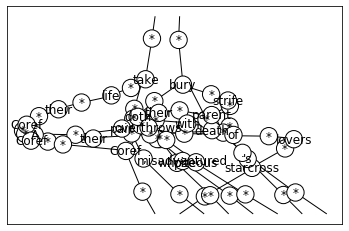

In [6]:
from discopy import monoidal, rigid
from discopy.hypergraph import Id, Ty, Box, Diagram, Spider

def relabel(diagram, ob):
    if isinstance(diagram, Ty):
        return Ty(*[ob(ty) for ty in diagram])
    if isinstance(diagram, Box):
        return Box(diagram.name, relabel(diagram.dom, ob), relabel(diagram.cod, ob))
    if isinstance(diagram, Diagram):
        boxes = [relabel(box, ob) for box in diagram.boxes]
        return Diagram(relabel(diagram.dom, ob), relabel(diagram.cod, ob), boxes, diagram.wires)
    if isinstance(diagram, monoidal.Ty):
        return Ty(*[ob(ty) for ty in diagram])
    raise NotImplementedError()

ob = lambda x: '*'
relabel(resolve(text, clusters), ob).draw()

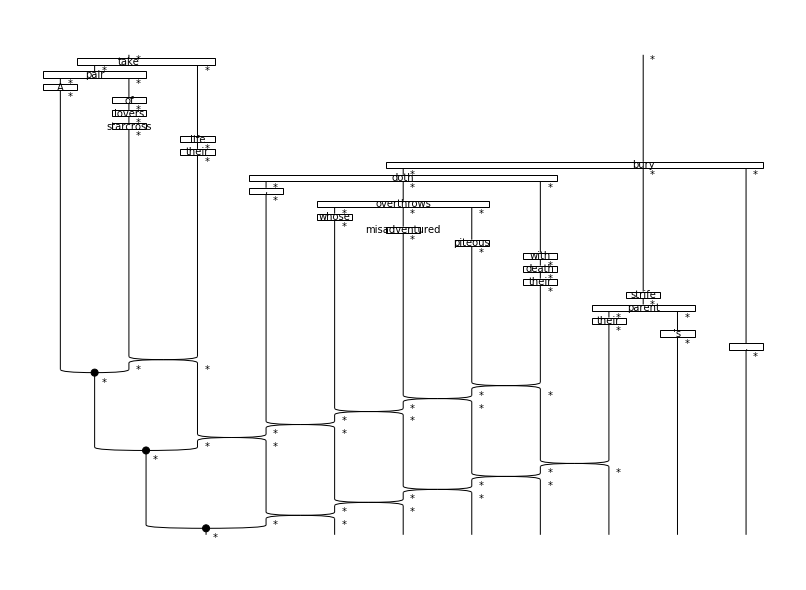

In [7]:
F = rigid.Functor(ob=lambda x: rigid.Ty(*x), ar=lambda box: rigid.Spider(2, 1, Ty('*')) 
                  if box.name == 'Coref' else rigid.Box(box.name, F(box.dom), F(box.cod)))
F(relabel(resolve(text, clusters), ob).downgrade()).draw(figsize=(11, 8))